# Analysis of the impact of shipping mode on revenue & cost 

Objective: estimate the impact of `Ship Mode` on revenue (`Sales`) and cost (estimate `Cost = Sales - Profit`) using Maximum Likelihood model (OLS ~ normal distribution).

Using control variables for region (`Region`) and product category (`Category`) to adjust for demand variance.

# 1. MLE model (OLS ~ Gaussian)

In [17]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
from pathlib import Path

DATA_PATH = Path("/kaggle/input/retail-supply-chain-sales-analysis/retail-sales-raw-data.xlsx")
ORDERS_SHEET = 'Retails Order Full Dataset'

orders = pd.read_excel(DATA_PATH, sheet_name=ORDERS_SHEET)
orders.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Retail Sales People,Product ID,Category,Sub-Category,Product Name,Returned,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-08-11,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,Cassandra Brandow,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,Not,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-08-11,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,Cassandra Brandow,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Not,731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-12-06,2016-12-06,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,Anna Andreadi,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,Not,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-11-10,2015-11-10,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,Cassandra Brandow,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,Not,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-11-10,2015-11-10,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,Cassandra Brandow,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,Not,22.3680,2,0.20,2.5164


### Preprocessing
* **Keep Valid Rows:** Filter the dataset to retain only rows with valid (non-null) values for `Ship Mode`, `Sales`, `Profit`, `Region`, and `Category`.
* **Calculate Cost:** Derive the `Cost` using the formula `Cost = Sales - Profit`.
* **Log Transformation (Log1p):** Apply `log1p` to reduce skewness in financial data.
* **Categorical Conversion:** Convert relevant columns to the `category` data type for efficient modeling.

In [18]:
# 1. Drop rows with missing values in key columns
orders_clean = orders.dropna(subset=['Ship Mode', 'Sales', 'Profit', 'Region', 'Category']).copy()

# 2. Cost Estimation: Calculate Cost as Sales minus Profit
orders_clean['Cost'] = orders_clean['Sales'] - orders_clean['Profit']

# 3. Normalize Column Names & Types
# Convert categorical variables to 'category' dtype for model efficiency
orders_clean['ship_mode'] = orders_clean['Ship Mode'].astype('category')
orders_clean['region'] = orders_clean['Region'].astype('category')
orders_clean['category'] = orders_clean['Category'].astype('category')

# 4. Log Transformation to Stabilize Variance
# Note: Financial data (Sales, Cost) is typically right-skewed, meaning there are many small orders and a few very large ones (outliers).
# Applying log1p (log(1+x)) helps normalize this distribution.
# Use .clip(lower=0) to handle rare cases where Cost < 0 (e.g., when Profit > Sales due to refunds or adjustments) before logging.
orders_clean['log_sales'] = np.log1p(orders_clean['Sales'])
orders_clean['log_cost'] = np.log1p(orders_clean['Cost'].clip(lower=0))

# Preview the processed data
orders_clean[['ship_mode', 'region', 'category', 'Sales', 'Profit', 'Cost']].head()

,ship_mode,region,category,Sales,Profit,Cost
0,Second Class,South,Furniture,261.9600,41.9136,220.0464
1,Second Class,South,Furniture,731.9400,219.5820,512.3580
2,Second Class,West,Office Supplies,14.6200,6.8714,7.7486
3,Standard Class,South,Furniture,957.5775,-383.0310,1340.6085
4,Standard Class,South,Office Supplies,22.3680,2.5164,19.8516


### MLE model (OLS ~ Gaussian)
We compare two types of models to demonstrate the importance of controlling for confounding variables.

- **Uncontrolled Model:** `log_sales ~ C(ship_mode)` and `log_cost ~ C(ship_mode)`
  - **Meaning:** Examines the direct relationship between shipping mode and revenue/cost.
  - **Limitation:** Ignores confounding variables. For example, higher revenue for *First Class* could be due to expensive items, not the shipping method itself.

- **Controlled Model:** `log_sales ~ C(ship_mode) + C(region) + C(category)` (similarly for `log_cost`)
  - **Meaning:** A multivariate regression model that includes `Region` and `Category` as control variables. `C(...)` creates dummy variables, using the first alphabetical value as the reference.
  - **Benefit:** Isolates the true impact of `ship_mode` by holding `Region` and `Category` constant. This allows for an accurate comparison of shipping modes for similar products in the same region.



In [19]:
# Uncontrolled model
model_sales = smf.ols('log_sales ~ C(ship_mode)', data=orders_clean).fit()
model_cost = smf.ols('log_cost ~ C(ship_mode)', data=orders_clean).fit()

# Model with area + category control
model_sales_ctrl = smf.ols('log_sales ~ C(ship_mode) + C(region) + C(category)', data=orders_clean).fit()
model_cost_ctrl = smf.ols('log_cost ~ C(ship_mode) + C(region) + C(category)', data=orders_clean).fit()

print('Revenue (log_sales) - uncontrolled')
print(model_sales.summary().tables[1])
print('Cost (log_cost) - uncontrolled')
print(model_cost.summary().tables[1])

print('=== Revenue (log_sales) - with controlled Region + Category  ===')
print(model_sales_ctrl.summary().tables[1])
print('=== Cost (log cost) - with controlled Region + Category ===')
print(model_cost_ctrl.summary().tables[1])


Revenue (log_sales) - uncontrolled
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          4.1624      0.041    102.676      0.000       4.083       4.242
C(ship_mode)[T.Same Day]           0.0086      0.079      0.108      0.914      -0.147       0.164
C(ship_mode)[T.Second Class]       0.0400      0.054      0.738      0.461      -0.066       0.146
C(ship_mode)[T.Standard Class]    -0.0243      0.045     -0.535      0.593      -0.113       0.065
Cost (log_cost) - uncontrolled
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          3.9616      0.042     95.089      0.000       3.880       4.043
C(ship_mode)[T.Same Day]          -0.0100  

### **1. Shipping Mode Has No Significant Impact on Revenue or Cost**
- Across all models (uncontrolled and controlled), the p-values for all shipping modes are **greater than 0.05**.
- This indicates that choosing Same Day, Second Class, or Standard Class does **not** produce a statistically significant difference in revenue or cost compared to the reference mode (First Class).
- The coefficients are also very close to zero, reinforcing the lack of meaningful impact.

**→ Shipping mode is not a key driver of financial performance.**

---

### **2. Product Category Is the Strongest Driver of Revenue and Cost**
- In the controlled models, **Product Category** is highly significant (p-value = 0.000) for both revenue and cost.
- Compared to the reference category (Furniture):
  - **Office Supplies** shows a strong negative effect on both log_sales (-1.4261) and log_cost (-1.5938), meaning substantially lower revenue and cost.
  - **Technology** has a positive effect on revenue (+0.1765), indicating higher sales performance.

**→ What you sell (Category) matters far more than how you ship it.**

---

### **3. Regional Differences Affect Revenue but Not Cost**
- For revenue:
  - East, South, and West all show **positive and significant** coefficients (p < 0.05), meaning these regions have higher sales compared to the Central region.
- For cost:
  - All regional p-values are **greater than 0.05**, indicating no meaningful difference in cost across regions.

**→ Revenue varies by region, but costs remain consistent regardless of location.**

---

### **Conclusion**
Shipping mode does not meaningfully influence revenue or cost. Instead, **Product Category** and **Region** are the main drivers of financial outcomes. Businesses should prioritize optimizing their **product mix** and **regional strategies**, rather than expecting faster shipping options to significantly impact revenue or cost structures.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


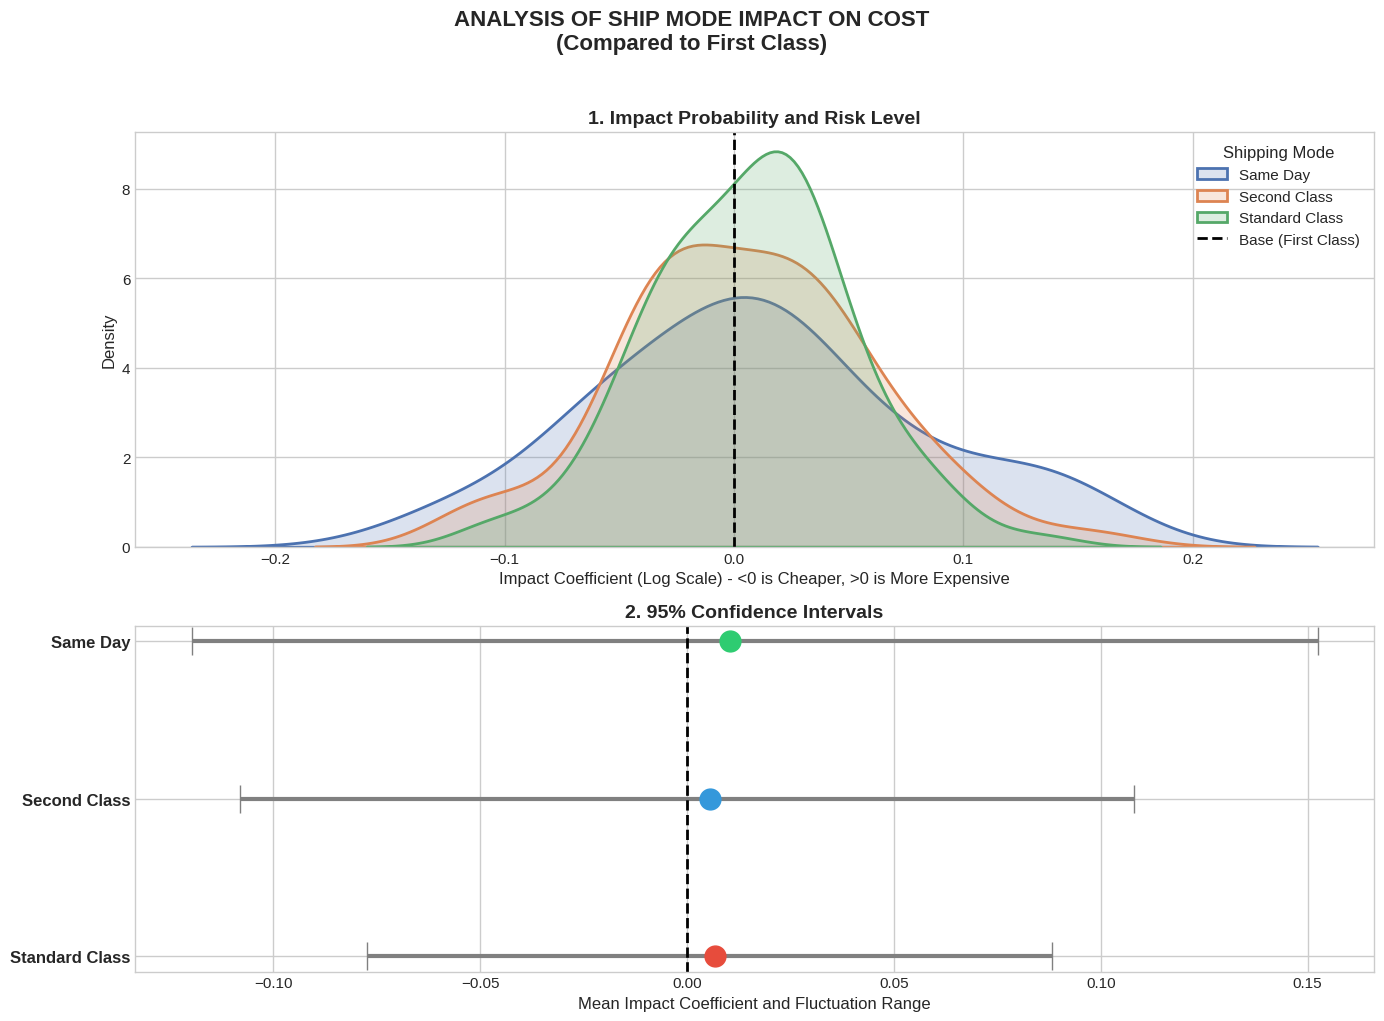

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from tqdm import tqdm

# Display Configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)

# 1. READ AND PROCESS DATA
file_path = '/kaggle/input/retail-supply-chain-sales-analysis/Retails Order Full Dataset.csv'
df_orders = pd.read_csv(file_path)

def prepare_data(df):
    df_clean = df.copy()
    for col in ['Sales', 'Profit']:
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].astype(str).str.replace(',', '').str.replace('$', '', regex=False)
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    df_clean = df_clean.dropna(subset=['Ship Mode', 'Sales', 'Profit', 'Region', 'Category'])
    df_clean['Cost'] = df_clean['Sales'] - df_clean['Profit']
    
    df_clean.rename(columns={'Ship Mode': 'ShipMode', 'Region': 'Region', 'Category': 'Category'}, inplace=True)
    df_clean['log_cost'] = np.log1p(df_clean['Cost'].clip(lower=0))
    return df_clean

df_model = prepare_data(df_orders)

# 2. RUN BOOTSTRAP
N_BOOTSTRAPS = 100
bootstrap_coefs = []
formula = 'log_cost ~ C(ShipMode) + C(Region) + C(Category)'

for i in range(N_BOOTSTRAPS):
    try:
        sample_df = df_model.sample(frac=1.0, replace=True)
        model = smf.ols(formula, data=sample_df).fit()
        params = model.params
        ship_mode_params = params[params.index.str.contains("ShipMode")]
        bootstrap_coefs.append(ship_mode_params)
    except:
        continue

df_boot_results = pd.DataFrame(bootstrap_coefs)
df_boot_results.columns = [col.split('[T.')[1].replace(']', '') for col in df_boot_results.columns]

# 3. PLOT CHARTS (FIXED)
fig, axes = plt.subplots(2, 1, height_ratios=[1.2, 1], figsize=(14, 10))
fig.suptitle('ANALYSIS OF SHIP MODE IMPACT ON COST\n(Compared to First Class)', 
             fontsize=16, fontweight='bold', y=1.02)

# Chart 1: KDE Plot
ax1 = axes[0]
for col in df_boot_results.columns:
    sns.kdeplot(df_boot_results[col], ax=ax1, fill=True, alpha=0.2, linewidth=2, label=col)
ax1.axvline(0, color='black', linestyle='--', linewidth=2, label='Base (First Class)')
ax1.set_title("1. Impact Probability and Risk Level", fontsize=14, fontweight='bold')
ax1.set_xlabel("Impact Coefficient (Log Scale) - <0 is Cheaper, >0 is More Expensive")
ax1.legend(title="Shipping Mode")

# Chart 2: Confidence Intervals
ax2 = axes[1]
means = df_boot_results.mean()
errors = [means - df_boot_results.quantile(0.025), df_boot_results.quantile(0.975) - means]
# Colors for points
colors = ['#2ecc71', '#3498db', '#e74c3c'] 
y_positions = range(len(means))

# Fix: Use a single color for error bars to avoid ValueError
ax2.errorbar(means, y_positions, xerr=errors, fmt='o', markersize=0, # Hide markers here
             capsize=10, linewidth=3, color='gray', ecolor='gray') 

# Plot colored points on top
for i, (mean, color) in enumerate(zip(means, colors)):
    ax2.plot(mean, i, 'o', markersize=15, color=color)

ax2.axvline(0, color='black', linestyle='--', linewidth=2)
ax2.set_yticks(y_positions)
ax2.set_yticklabels(df_boot_results.columns, fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.set_title("2. 95% Confidence Intervals", fontsize=14, fontweight='bold')
ax2.set_xlabel("Mean Impact Coefficient and Fluctuation Range")

plt.tight_layout()
plt.show()

### Expected revenue/cost by shipping method (controlled)
Transform the log coefficients to the original scale (expm1) for comparison. 
Fixed `Region` and `Category` at the most common value to isolate the effect of `Ship Mode`.

In [5]:

# Get modal values ​​for region and category to fix when forecasting
region_mode = orders_clean['region'].mode()[0]
category_mode = orders_clean['category'].mode()[0] #mode()[0]: Tìm giá trị xuất hiện nhiều nhất (mốt) trong dữ liệu.

ship_modes = orders_clean['ship_mode'].cat.categories
pred_table = []
for mode in ship_modes:
    df_mode = pd.DataFrame({'ship_mode': [mode], 'region': [region_mode], 'category': [category_mode]})
    pred_log_sales = model_sales_ctrl.predict(df_mode)[0]
    pred_log_cost = model_cost_ctrl.predict(df_mode)[0]
    pred_table.append({
        'Ship Mode': mode,
        'Region (fixed)': region_mode,
        'Category (fixed)': category_mode,
        'Pred Sales (mean)': np.expm1(pred_log_sales),
        'Pred Cost (mean)': np.expm1(pred_log_cost)
    })

pred_df = pd.DataFrame(pred_table).sort_values('Pred Sales (mean)', ascending=False)
pred_df


,Ship Mode,Region (fixed),Category (fixed),Pred Sales (mean),Pred Cost (mean)
2,Second Class,West,Office Supplies,37.803334,26.304284
1,Same Day,West,Office Supplies,36.953449,26.119456
3,Standard Class,West,Office Supplies,36.360069,26.142271
0,First Class,West,Office Supplies,35.942060,26.014697


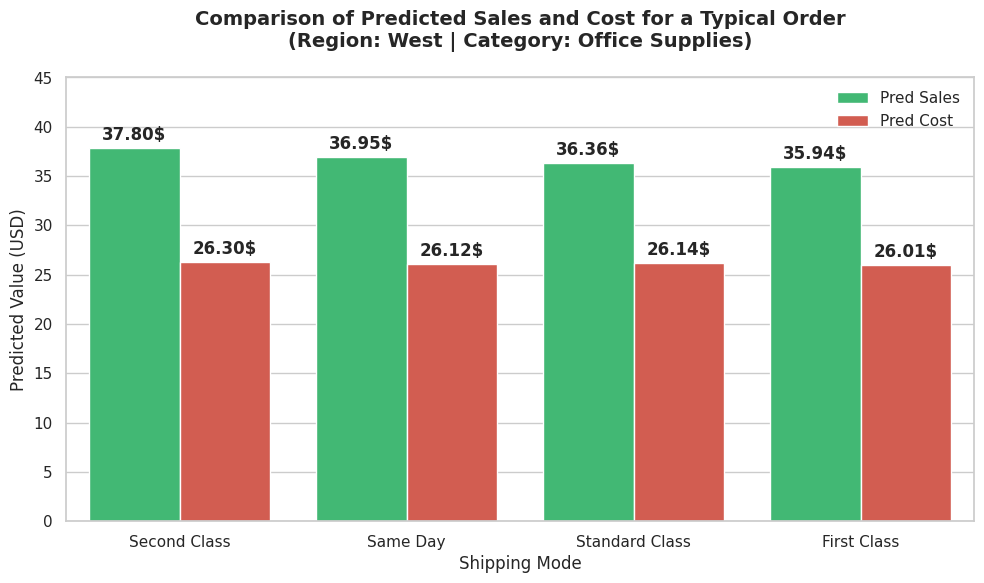

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Recreate data from your results table
data = {
    'Ship Mode': ['Second Class', 'Same Day', 'Standard Class', 'First Class'],
    'Pred Sales': [37.80, 36.95, 36.36, 35.94],
    'Pred Cost': [26.30, 26.12, 26.14, 26.01]
}
df_pred = pd.DataFrame(data)

# 2. Prepare data for Seaborn (Melt from wide to long format)
df_melted = df_pred.melt(id_vars='Ship Mode', var_name='Metric', value_name='Value ($)')

# 3. Plot the chart
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Plot Grouped Bar Chart
ax = sns.barplot(data=df_melted, x='Ship Mode', y='Value ($)', hue='Metric', 
                 palette=['#2ecc71', '#e74c3c']) # Green for Sales, Red for Cost

# Add value labels to the top of columns
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f$', padding=3, fontweight='bold')

# Customize plot
plt.title('Comparison of Predicted Sales and Cost for a Typical Order\n(Region: West | Category: Office Supplies)', 
          fontsize=14, fontweight='bold', y=1.05)
plt.ylabel("Predicted Value (USD)")
plt.xlabel("Shipping Mode")
plt.ylim(0, 45) # Set Y limit to visualize the scale clearly
plt.legend(title=None, loc='upper right')

plt.tight_layout()
plt.show()

### Notes
- Positive coefficient in `C(ship_mode)[T.*]` => higher revenue/cost than reference group (standard ship mode) after fixing Region + Category.
  
- `Pred Sales/Pred Cost` provides a practical comparison between ship modes in the same regional & popular category context.
  
- `region_mode`, `category_mode` can be replaced with other values ​​or weighted average to reflect the sales channel reality.

Training OLS models...
Predicting for 48 combinations (ShipMode x Region x Category)...


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_

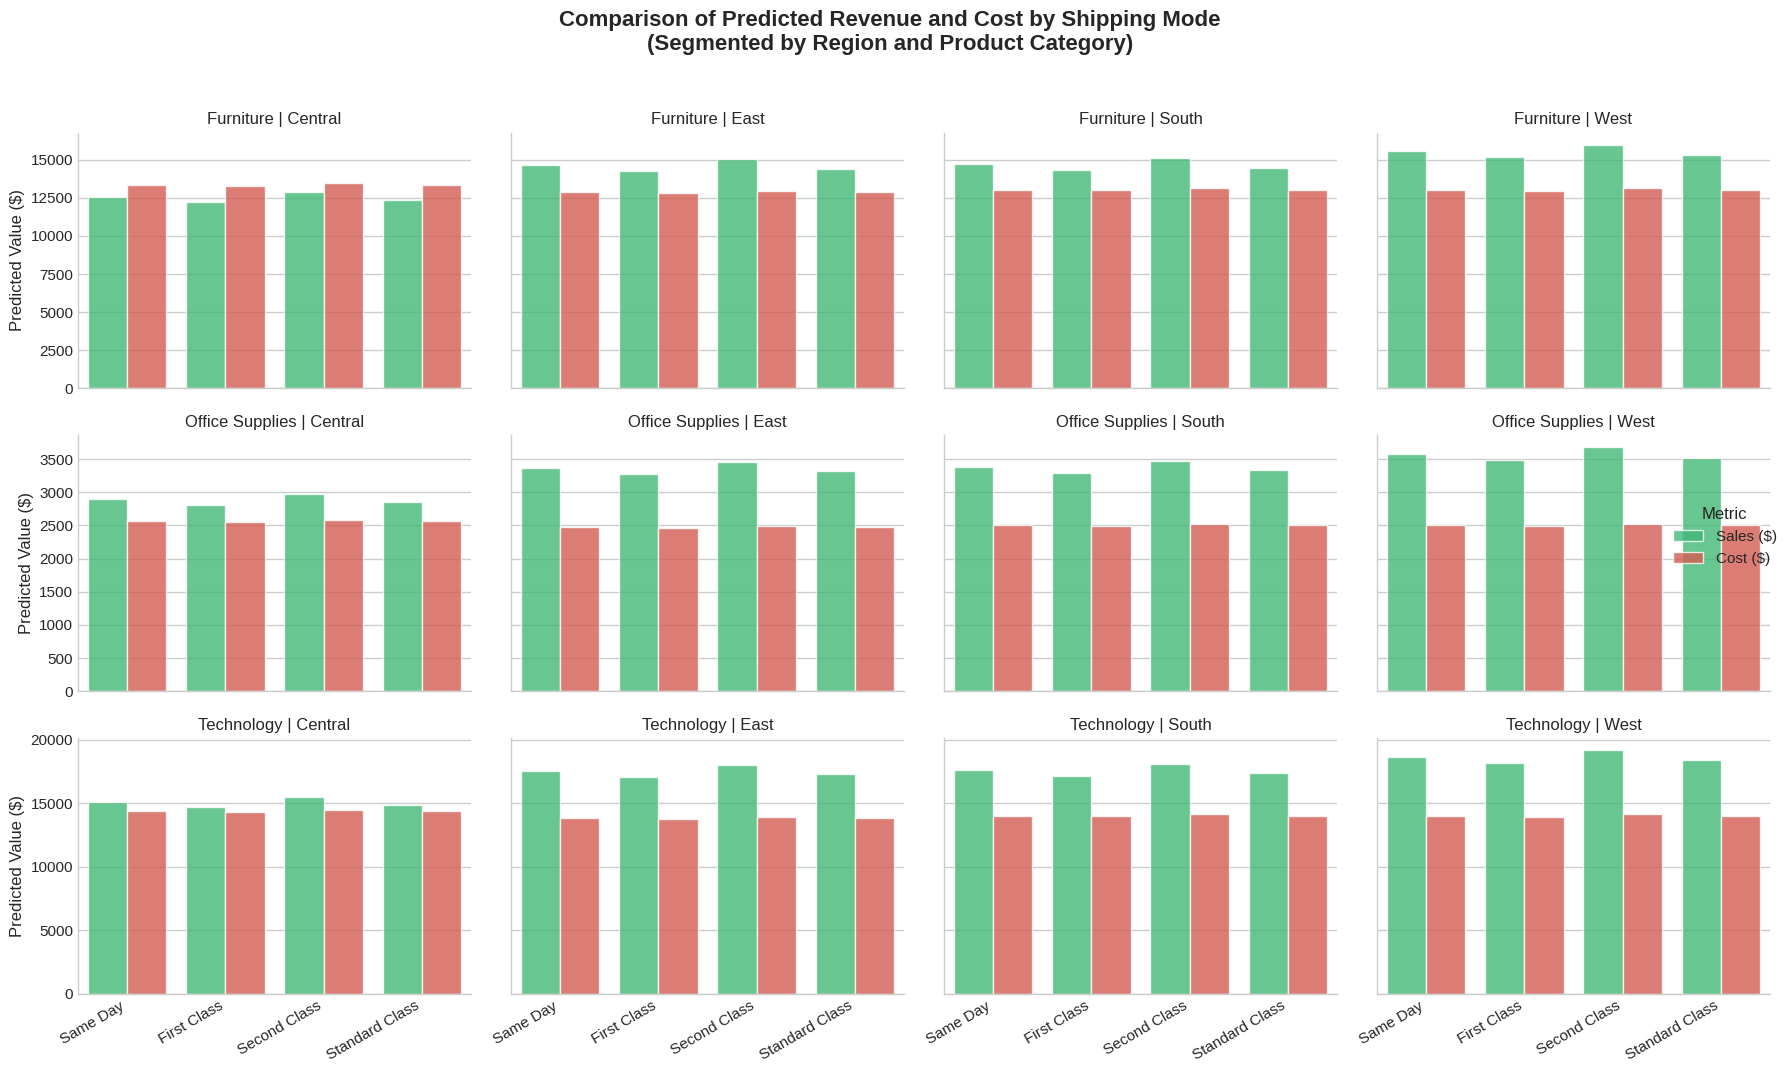


=== TOP 5 HIGHEST PREDICTED PROFIT COMBINATIONS ===
   Region    Category        ShipMode     Sales ($)      Cost ($)   Profit ($)
5    West  Technology    Second Class  19175.237363  14124.085102  5051.152260
41   West  Technology        Same Day  18681.131548  14015.308337  4665.823212
17   West  Technology  Standard Class  18385.981390  14017.801254  4368.180136
29   West  Technology     First Class  18175.359149  13956.803746  4218.555403
11   East  Technology    Second Class  18029.309921  13951.368917  4077.941004

=== BOTTOM 5 LOWEST PREDICTED PROFIT COMBINATIONS ===
     Region         Category        ShipMode     Sales ($)      Cost ($)  \
30  Central        Furniture     First Class  12237.808117  13290.329076   
18  Central        Furniture  Standard Class  12379.627784  13348.413999   
42  Central        Furniture        Same Day  12578.363192  13346.040116   
6   Central        Furniture    Second Class  12911.062728  13449.622873   
31  Central  Office Supplies     First

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import itertools

# Display Configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_columns', None)

# ==========================================
# 1. DATA PREPARATION & MODEL TRAINING
# ==========================================
file_path = '/kaggle/input/retail-supply-chain-sales-analysis/Retails Order Full Dataset.csv'
df_orders = pd.read_csv(file_path)

def prepare_data(df):
    df_clean = df.copy()
    # Handle numeric conversion
    for col in ['Sales', 'Profit']:
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].astype(str).str.replace(',', '').str.replace('$', '', regex=False)
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Drop missing values
    df_clean = df_clean.dropna(subset=['Ship Mode', 'Sales', 'Profit', 'Region', 'Category'])
    
    # Calculate Cost
    df_clean['Cost'] = df_clean['Sales'] - df_clean['Profit']
    
    # Rename columns for formula compatibility
    df_clean.rename(columns={'Ship Mode': 'ShipMode', 'Region': 'Region', 'Category': 'Category'}, inplace=True)
    
    # Log transform
    df_clean['log_sales'] = np.log1p(df_clean['Sales'])
    df_clean['log_cost'] = np.log1p(df_clean['Cost'].clip(lower=0))
    return df_clean

df_model = prepare_data(df_orders)

# Train 2 OLS models (Sales and Cost) on the full dataset
# (Used to predict expected average values)
print("Training OLS models...")
model_sales = smf.ols('log_sales ~ C(ShipMode) + C(Region) + C(Category)', data=df_model).fit()
model_cost = smf.ols('log_cost ~ C(ShipMode) + C(Region) + C(Category)', data=df_model).fit()

# ==========================================
# 2. GENERATE PREDICTION GRID (All Combinations)
# ==========================================
# Get unique values
ship_modes = df_model['ShipMode'].unique()
regions = df_model['Region'].unique()
categories = df_model['Category'].unique()

# Create Cartesian product of all combinations
combinations = list(itertools.product(ship_modes, regions, categories))
pred_df = pd.DataFrame(combinations, columns=['ShipMode', 'Region', 'Category'])

print(f"Predicting for {len(pred_df)} combinations (ShipMode x Region x Category)...")

# Predict Log Sales and Log Cost
pred_df['pred_log_sales'] = model_sales.predict(pred_df)
pred_df['pred_log_cost'] = model_cost.predict(pred_df)

# Reverse transformation to USD (expm1)
pred_df['Sales ($)'] = np.expm1(pred_df['pred_log_sales'])
pred_df['Cost ($)'] = np.expm1(pred_df['pred_log_cost'])
pred_df['Profit ($)'] = pred_df['Sales ($)'] - pred_df['Cost ($)'] # Estimated Gross Profit

# Sort for better visualization
ship_mode_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class'] # Desired order
pred_df['ShipMode'] = pd.Categorical(pred_df['ShipMode'], categories=ship_mode_order, ordered=True)
pred_df.sort_values(['Category', 'Region', 'ShipMode'], inplace=True)

# ==========================================
# 3. VISUALIZATION: MULTI-DIMENSIONAL COMPARISON
# ==========================================

# We use FacetGrid to plot:
# - Columns: By Region
# - Rows: By Category
# - X-axis: Ship Mode
# - Y-axis: Value ($) of Sales and Cost

# Melt data to long format to plot Sales and Cost together
df_plot = pred_df.melt(id_vars=['ShipMode', 'Region', 'Category'], 
                       value_vars=['Sales ($)', 'Cost ($)'], 
                       var_name='Metric', value_name='Value')

# Plot FacetGrid
g = sns.catplot(
    data=df_plot, x='ShipMode', y='Value', hue='Metric',
    col='Region', row='Category',
    kind='bar', height=3.5, aspect=1.2,
    palette=['#2ecc71', '#e74c3c'], # Green for Sales, Red for Cost
    sharey='row', # Share Y-axis across rows for easy comparison
    alpha=0.8
)

# Decorate the plot
g.fig.suptitle("Comparison of Predicted Revenue and Cost by Shipping Mode\n(Segmented by Region and Product Category)", 
               y=1.02, fontsize=16, fontweight='bold')
g.set_axis_labels("", "Predicted Value ($)")
g.set_titles("{row_name} | {col_name}")

# Rotate X-axis labels for readability
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_ha('right')

plt.tight_layout()
plt.show()

# ==========================================
# 4. DISPLAY TOP 5 & BOTTOM 5 PROFITABLE COMBINATIONS
# ==========================================
print("\n=== TOP 5 HIGHEST PREDICTED PROFIT COMBINATIONS ===")
print(pred_df.sort_values('Profit ($)', ascending=False).head(5)[['Region', 'Category', 'ShipMode', 'Sales ($)', 'Cost ($)', 'Profit ($)']])

print("\n=== BOTTOM 5 LOWEST PREDICTED PROFIT COMBINATIONS ===")
print(pred_df.sort_values('Profit ($)', ascending=True).head(5)[['Region', 'Category', 'ShipMode', 'Sales ($)', 'Cost ($)', 'Profit ($)']])

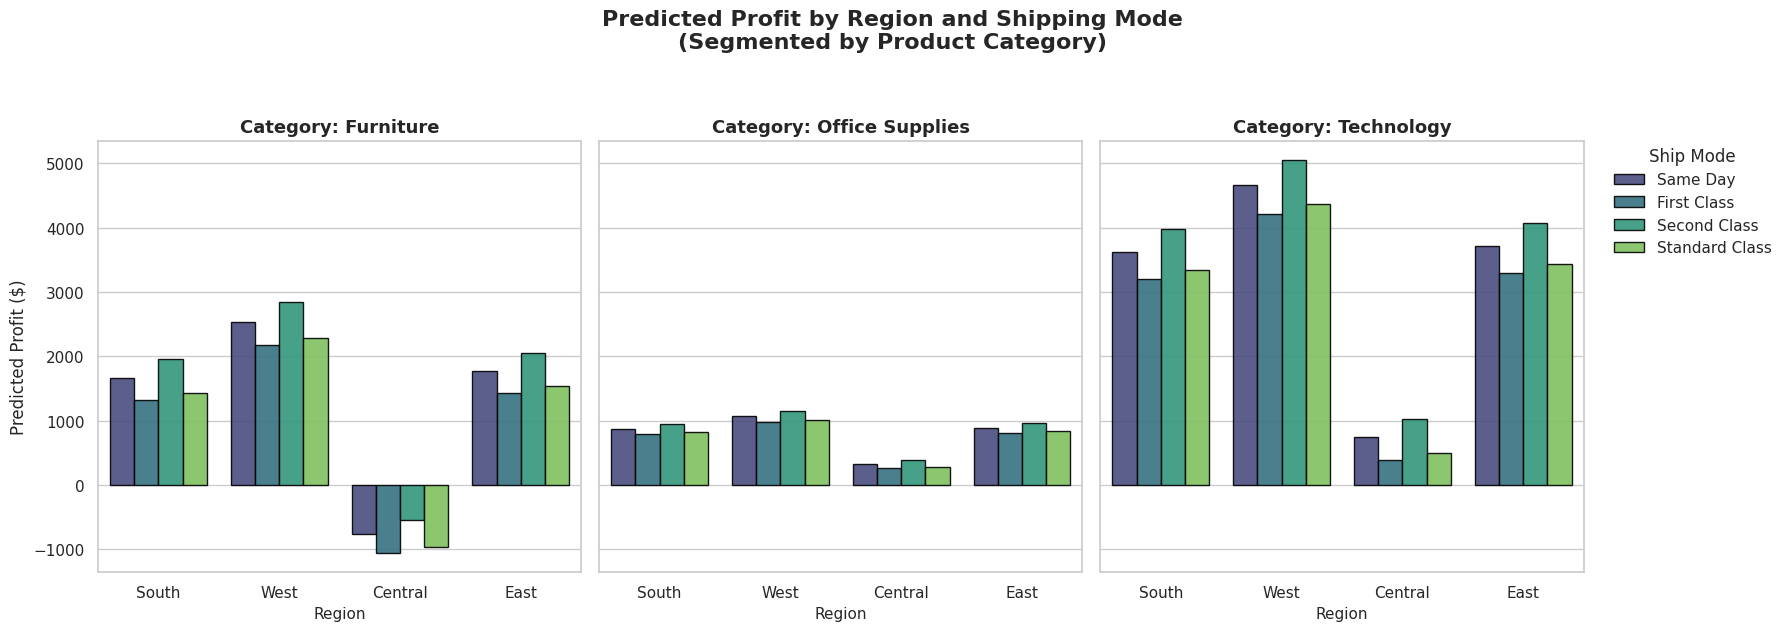

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


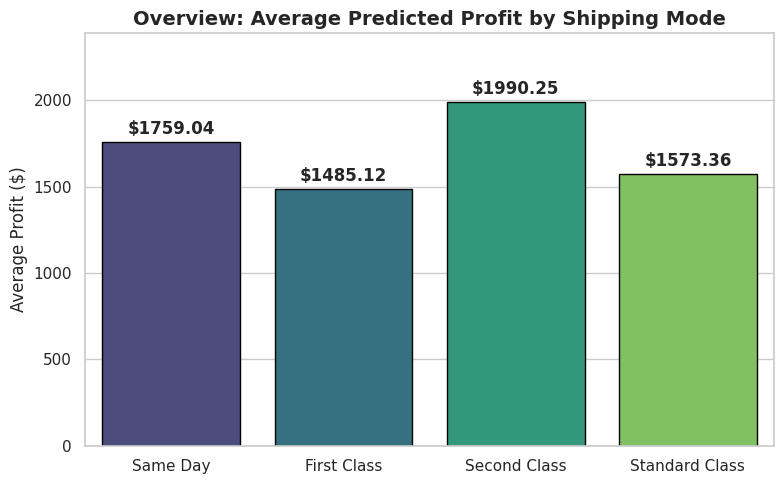

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import itertools

# 1. DATA PREPARATION & MODEL TRAINING (Same as before)
file_path = '/kaggle/input/retail-supply-chain-sales-analysis/Retails Order Full Dataset.csv'
df_orders = pd.read_csv(file_path)

def prepare_data(df):
    df_clean = df.copy()
    # Handle numeric conversion
    for col in ['Sales', 'Profit']:
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].astype(str).str.replace(',', '').str.replace('$', '', regex=False)
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Drop missing values and calculate cost
    df_clean = df_clean.dropna(subset=['Ship Mode', 'Sales', 'Profit', 'Region', 'Category'])
    df_clean['Cost'] = df_clean['Sales'] - df_clean['Profit']
    df_clean.rename(columns={'Ship Mode': 'ShipMode', 'Region': 'Region', 'Category': 'Category'}, inplace=True)
    
    # Log transform
    df_clean['log_sales'] = np.log1p(df_clean['Sales'])
    df_clean['log_cost'] = np.log1p(df_clean['Cost'].clip(lower=0))
    return df_clean

df_model = prepare_data(df_orders)

# Train OLS models
model_sales = smf.ols('log_sales ~ C(ShipMode) + C(Region) + C(Category)', data=df_model).fit()
model_cost = smf.ols('log_cost ~ C(ShipMode) + C(Region) + C(Category)', data=df_model).fit()

# Create Prediction Grid
ship_modes = df_model['ShipMode'].unique()
regions = df_model['Region'].unique()
categories = df_model['Category'].unique()
combinations = list(itertools.product(ship_modes, regions, categories))
pred_df = pd.DataFrame(combinations, columns=['ShipMode', 'Region', 'Category'])

# Predict and reverse transform (Log -> USD)
pred_df['pred_log_sales'] = model_sales.predict(pred_df)
pred_df['pred_log_cost'] = model_cost.predict(pred_df)
pred_df['Sales ($)'] = np.expm1(pred_df['pred_log_sales'])
pred_df['Cost ($)'] = np.expm1(pred_df['pred_log_cost'])
pred_df['Profit ($)'] = pred_df['Sales ($)'] - pred_df['Cost ($)']

# Sort Ship Mode for better display
ship_mode_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
pred_df['ShipMode'] = pd.Categorical(pred_df['ShipMode'], categories=ship_mode_order, ordered=True)


# ==========================================
# 2. COMBINED CHART (3 Subplots)
# ==========================================
sns.set_theme(style="whitegrid")

# Create figure: 1 row x 3 columns (for 3 Categories)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True) 
fig.suptitle('Predicted Profit by Region and Shipping Mode\n(Segmented by Product Category)', 
             fontsize=16, fontweight='bold', y=1.05)

# Get Categories and Palette
categories = sorted(pred_df['Category'].unique())
palette = sns.color_palette("viridis", n_colors=4) 

for i, cat in enumerate(categories):
    ax = axes[i]
    # Filter data for each Category
    data_cat = pred_df[pred_df['Category'] == cat]
    
    # Draw Bar Chart: X=Region, Hue=ShipMode
    sns.barplot(data=data_cat, x='Region', y='Profit ($)', hue='ShipMode', 
                ax=ax, palette=palette, edgecolor='black', alpha=0.9)
    
    # Decorate
    ax.set_title(f'Category: {cat}', fontweight='bold', fontsize=13)
    ax.set_xlabel("Region", fontsize=11)
    
    # Show Y label only on the first plot
    if i == 0:
        ax.set_ylabel("Predicted Profit ($)", fontsize=12)
    else:
        ax.set_ylabel("") 
    
    # Handle Legend (Show only on the first plot to save space, or adjust position)
    if i < 2:
        if ax.get_legend() is not None: ax.get_legend().remove()
    else:
        ax.legend(title='Ship Mode', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()

# ==========================================
# 3. GRAND SUMMARY CHART (Average)
# ==========================================
plt.figure(figsize=(8, 5))
# Calculate average Profit for each Ship Mode (ignoring Region and Category)
avg_profit = pred_df.groupby('ShipMode', observed=True)['Profit ($)'].mean().reset_index()

# Draw simple bar chart
ax = sns.barplot(data=avg_profit, x='ShipMode', y='Profit ($)', palette='viridis', edgecolor='black')

# Add values on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='$%.2f', padding=3, fontweight='bold')

plt.title('Overview: Average Predicted Profit by Shipping Mode', fontweight='bold', fontsize=14)
plt.ylabel("Average Profit ($)")
plt.xlabel("")
plt.ylim(0, avg_profit['Profit ($)'].max() * 1.2) # Increase Y limit to avoid label overlap

plt.tight_layout()
plt.show()

# 2.2 Quantile regression 

Running OLS (Parametric)...
Running Quantile Regression (Non-Parametric)...

=== COMPARISON TABLE: SHIP MODE IMPACT (%) ON COST ===
         ShipMode              Model  Impact_Percent  P_value
0        Same Day         OLS (Mean)          0.4192   0.9549
1    Second Class         OLS (Mean)          1.1985   0.8140
2  Standard Class         OLS (Mean)          0.4370   0.9182
3        Same Day  Quantile (Median)         -5.5971   0.5432
4    Second Class  Quantile (Median)         -4.1908   0.5088
5  Standard Class  Quantile (Median)         -4.1786   0.4320


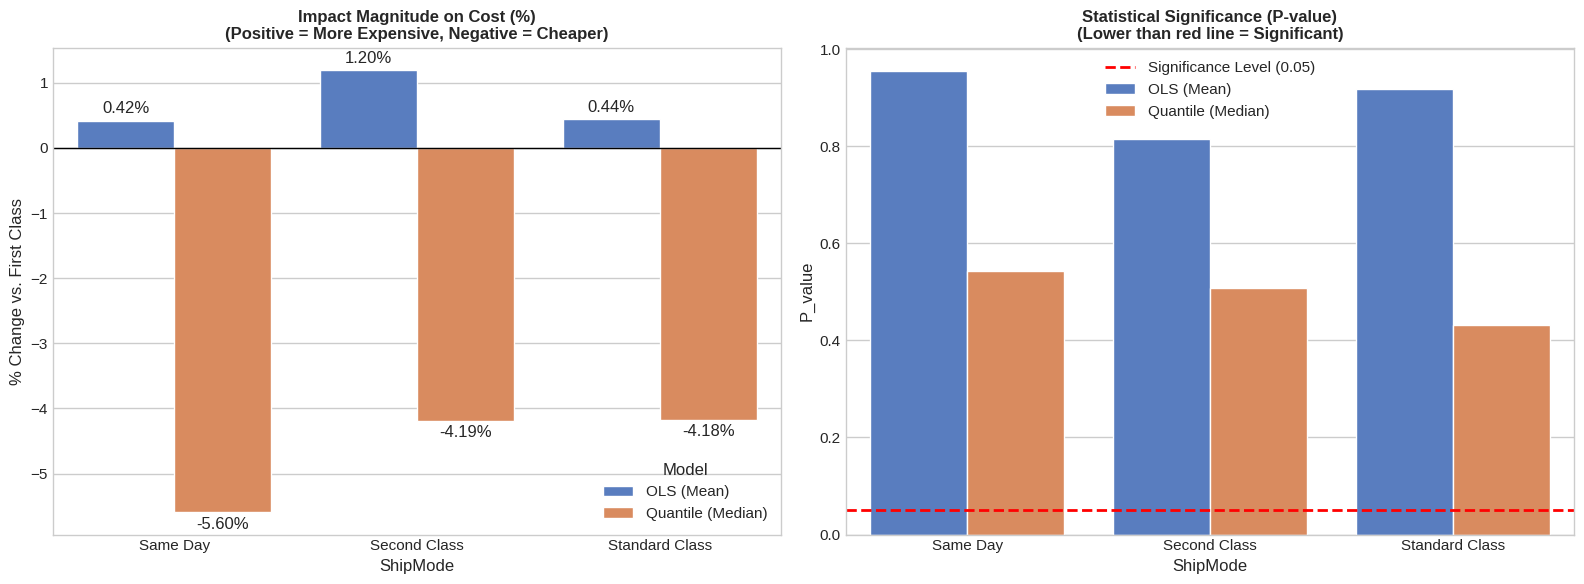


=== ANALYTICAL CONCLUSION ===
--- Same Day ---
  OLS (Mean): Impact 0.42%, statistically significant: NO
  Quantile (Median): Impact -5.60%, statistically significant: NO
  => CONCLUSION: Both models agree there is NO significant impact.

--- Second Class ---
  OLS (Mean): Impact 1.20%, statistically significant: NO
  Quantile (Median): Impact -4.19%, statistically significant: NO
  => CONCLUSION: Both models agree there is NO significant impact.

--- Standard Class ---
  OLS (Mean): Impact 0.44%, statistically significant: NO
  Quantile (Median): Impact -4.18%, statistically significant: NO
  => CONCLUSION: Both models agree there is NO significant impact.



In [27]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Display Configuration
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# 1. DATA PREPARATION
file_path = '/kaggle/input/retail-supply-chain-sales-analysis/Retails Order Full Dataset.csv'
df_orders = pd.read_csv(file_path)

def prepare_data(df):
    df_clean = df.copy()
    # Handle numeric conversion
    for col in ['Sales', 'Profit']:
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].astype(str).str.replace(',', '').str.replace('$', '', regex=False)
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Drop missing values and calculate Cost
    df_clean = df_clean.dropna(subset=['Ship Mode', 'Sales', 'Profit', 'Region', 'Category'])
    df_clean['Cost'] = df_clean['Sales'] - df_clean['Profit']
    
    # Rename columns
    df_clean.rename(columns={'Ship Mode': 'ShipMode', 'Region': 'Region', 'Category': 'Category'}, inplace=True)
    
    # Log transformation
    df_clean['log_sales'] = np.log1p(df_clean['Sales'])
    df_clean['log_cost'] = np.log1p(df_clean['Cost'].clip(lower=0))
    return df_clean

df_model = prepare_data(df_orders)

# ==========================================
# 2. RUN TWO COMPETING MODELS
# ==========================================
formula = 'log_cost ~ C(ShipMode) + C(Region) + C(Category)'

# Model 1: OLS (Parametric - Mean Estimation)
print("Running OLS (Parametric)...")
model_ols = smf.ols(formula, data=df_model).fit()

# Model 2: Quantile Regression (Non-Parametric - Median Estimation)
# q=0.5 corresponds to Median Regression
print("Running Quantile Regression (Non-Parametric)...")
model_quant = smf.quantreg(formula, data=df_model).fit(q=0.5)

# ==========================================
# 3. AGGREGATE AND COMPARE RESULTS
# ==========================================
# Function to extract coefficients for Ship Mode
def get_ship_mode_coefs(model, model_name):
    # Get coefficients and p-values
    params = model.params
    pvals = model.pvalues
    # Filter only ShipMode parameters
    mask = params.index.str.contains("ShipMode")
    df_res = pd.DataFrame({
        'Coef_Log': params[mask],
        'P_value': pvals[mask]
    })
    df_res['Model'] = model_name
    # Convert Log coef to actual percentage impact: (e^coef - 1) * 100
    df_res['Impact_Percent'] = (np.exp(df_res['Coef_Log']) - 1) * 100
    
    # Clean up index names
    df_res.index = [idx.split('[T.')[1].replace(']', '') for idx in df_res.index]
    return df_res

# Combine results
res_ols = get_ship_mode_coefs(model_ols, 'OLS (Mean)')
res_quant = get_ship_mode_coefs(model_quant, 'Quantile (Median)')
df_comparison = pd.concat([res_ols, res_quant]).reset_index().rename(columns={'index': 'ShipMode'})

print("\n=== COMPARISON TABLE: SHIP MODE IMPACT (%) ON COST ===")
print(df_comparison[['ShipMode', 'Model', 'Impact_Percent', 'P_value']].round(4))

# ==========================================
# 4. VISUALIZATION: SIDE-BY-SIDE COMPARISON
# ==========================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Compare Impact Magnitude (%)
sns.barplot(data=df_comparison, x='ShipMode', y='Impact_Percent', hue='Model', ax=ax1, palette='muted')
ax1.axhline(0, color='black', linewidth=1)
ax1.set_title("Impact Magnitude on Cost (%)\n(Positive = More Expensive, Negative = Cheaper)", fontweight='bold')
ax1.set_ylabel("% Change vs. First Class")
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f%%', padding=3)

# Chart 2: Compare Statistical Significance (P-value)
# Draw reference line at P=0.05
sns.barplot(data=df_comparison, x='ShipMode', y='P_value', hue='Model', ax=ax2, palette='muted')
ax2.axhline(0.05, color='red', linestyle='--', label='Significance Level (0.05)', linewidth=2)
ax2.set_title("Statistical Significance (P-value)\n(Lower than red line = Significant)", fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

# ==========================================
# 5. AUTOMATED INSIGHTS
# ==========================================
print("\n=== ANALYTICAL CONCLUSION ===")
for mode in df_comparison['ShipMode'].unique():
    row_ols = df_comparison[(df_comparison['ShipMode'] == mode) & (df_comparison['Model'] == 'OLS (Mean)')].iloc[0]
    row_quant = df_comparison[(df_comparison['ShipMode'] == mode) & (df_comparison['Model'] == 'Quantile (Median)')].iloc[0]
    
    print(f"--- {mode} ---")
    # Check OLS
    ols_sig = "YES" if row_ols['P_value'] < 0.05 else "NO"
    print(f"  OLS (Mean): Impact {row_ols['Impact_Percent']:.2f}%, statistically significant: {ols_sig}")
    
    # Check Quantile
    quant_sig = "YES" if row_quant['P_value'] < 0.05 else "NO"
    print(f"  Quantile (Median): Impact {row_quant['Impact_Percent']:.2f}%, statistically significant: {quant_sig}")
    
    if ols_sig == "NO" and quant_sig == "NO":
        print("  => CONCLUSION: Both models agree there is NO significant impact.")
    elif ols_sig != quant_sig:
        print("  => CONCLUSION: Results differ. Trust Quantile Regression more as OLS might be affected by outliers.")
    print("")

Reading data...

--- OUTLIER ANALYSIS CHARTS ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


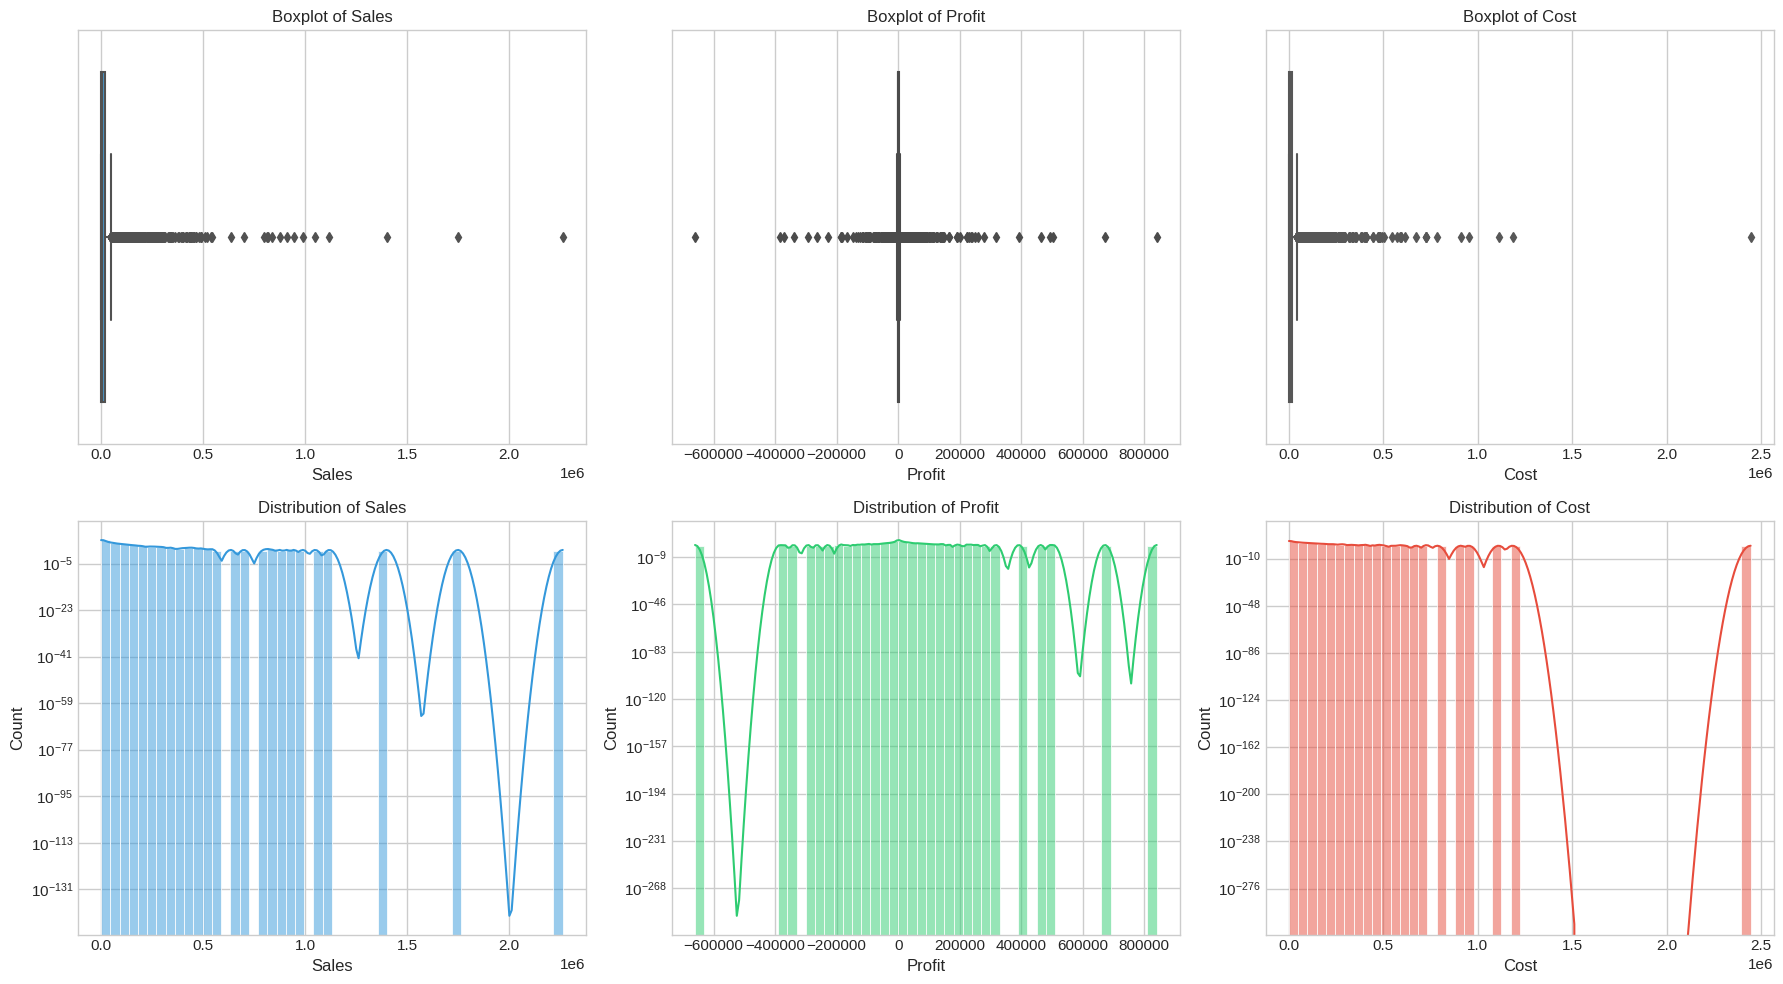


--- DETAILED STATISTICS ---
              Sales         Profit          Cost
count  9.994000e+03    9994.000000  9.994000e+03
mean   2.298580e+04    2865.697318  2.012010e+04
std    6.232451e+04   23426.020289  5.508394e+04
min    4.400000e+01 -659998.000000  5.500000e+01
1%     2.290000e+02  -31926.350000  2.039300e+02
5%     4.980000e+02   -5303.100000  4.036500e+02
25%    1.728000e+03     173.000000  1.269000e+03
50%    5.449000e+03     866.500000  4.166500e+03
75%    2.099400e+04    2936.000000  1.822275e+04
95%    9.569820e+04   16847.000000  8.630440e+04
99%    2.481695e+05   58065.830000  2.139440e+05
max    2.263848e+06  839998.000000  2.444956e+06

--- NUMBER OF OUTLIERS (IQR Method) ---
Sales:
  - Normal Range: [-27171.00, 49893.00]
  - Number of Outliers: 1167 (11.68%)
  - Max Value: 2263848
  - Min Value: 44
Profit:
  - Normal Range: [-3971.50, 7080.50]
  - Number of Outliers: 1881 (18.82%)
  - Max Value: 839998
  - Min Value: -659998
Cost:
  - Normal Range: [-24161.62, 43

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display Configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (16, 6)
pd.set_option('display.max_columns', None)

# 1. READ AND CLEAN DATA
file_path = '/kaggle/input/retail-supply-chain-sales-analysis/Retails Order Full Dataset.csv'
print("Reading data...")
df_orders = pd.read_csv(file_path)

def prepare_data_for_outlier_check(df):
    df_clean = df.copy()
    
    # Handle numeric conversion
    for col in ['Sales', 'Profit']:
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].astype(str).str.replace(',', '').str.replace('$', '', regex=False)
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # Drop missing values
    df_clean = df_clean.dropna(subset=['Sales', 'Profit'])
    
    # Calculate Cost for checking
    df_clean['Cost'] = df_clean['Sales'] - df_clean['Profit']
    
    return df_clean

df_check = prepare_data_for_outlier_check(df_orders)

# 2. VISUALIZE OUTLIERS (Boxplot & Histogram)
print("\n--- OUTLIER ANALYSIS CHARTS ---")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Variables to check
vars_to_check = ['Sales', 'Profit', 'Cost']
colors = ['#3498db', '#2ecc71', '#e74c3c']

# Plot Boxplots (Row 1) - Helps identify outliers outside whiskers
for i, var in enumerate(vars_to_check):
    sns.boxplot(x=df_check[var], ax=axes[0, i], color=colors[i])
    axes[0, i].set_title(f'Boxplot of {var}')

# Plot Histograms (Row 2) - Helps see distribution skewness
for i, var in enumerate(vars_to_check):
    sns.histplot(df_check[var], ax=axes[1, i], color=colors[i], kde=True, bins=50)
    axes[1, i].set_title(f'Distribution of {var}')
    axes[1, i].set_yscale('log') # Use Log scale for Y-axis to see low frequency bars clearly

plt.tight_layout()
plt.show()

# 3. DETAILED OUTLIER STATISTICS
print("\n--- DETAILED STATISTICS ---")
desc_stats = df_check[vars_to_check].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
print(desc_stats)

# Calculate Number of Outliers using IQR (Interquartile Range)
print("\n--- NUMBER OF OUTLIERS (IQR Method) ---")
for var in vars_to_check:
    Q1 = df_check[var].quantile(0.25)
    Q3 = df_check[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_check[(df_check[var] < lower_bound) | (df_check[var] > upper_bound)]
    n_outliers = len(outliers)
    pct_outliers = (n_outliers / len(df_check)) * 100
    
    print(f"{var}:")
    print(f"  - Normal Range: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  - Number of Outliers: {n_outliers} ({pct_outliers:.2f}%)")
    print(f"  - Max Value: {df_check[var].max()}")
    print(f"  - Min Value: {df_check[var].min()}")

Based on your outlier analysis results (Sales has ~11.7% outliers, Profit ~18.8%, and Cost ~12.3%), using standard OLS regression—which focuses on the mean—may be misleading because the mean is sensitive to extreme values.

Quantile Regression provides a more robust alternative for this type of data.

### Quantiles Used
The model evaluates three quantiles:

- **0.1 (10th percentile)** – small, low-cost orders  
- **0.5 (median)** – typical orders, more robust than the mean  
- **0.9 (90th percentile)** – large, high-cost orders (outliers or “whales”)

Instead of analyzing only the “average order,” this approach examines how shipping mode affects different segments of the cost distribution.

### Fitting the Quantile Regression Model
Using `smf.quantreg`, the code fits the regression three separate times—once per quantile.  
This allows the model to estimate how **Ship Mode** impacts:

- low-cost orders  
- typical orders  
- high-cost orders  

separately, rather than assuming the effect is constant across all order sizes.

### Extracting and Interpreting Coefficients
The model extracts the shipping mode coefficients for each quantile.  
Because the target variable **log_cost** is logarithmic, results are transformed back into interpretable percentages using:


`(\exp(\text{coef}) - 1) \times 100`


Example:  
A coefficient that transforms to **-5%** means:  
**“This shipping mode is 5% cheaper for that quantile.”**

### Statistical Significance
For each coefficient, P-values are checked to determine whether the observed difference is statistically meaningful.  
This ensures that large-looking effects (e.g., 10%) are not incorrectly interpreted if they are not significant.

### Visualization
A line plot illustrates how the effect of shipping mode changes across quantiles:

- **Flat lines** → shipping mode impact stays consistent regardless of order size  
- **Sloped lines** → impact increases or decreases as order size changes  

This reveals whether shipping mode becomes relatively more or less expensive for small vs. large orders.



Running Quantile Regression...

=== IMPACT OF SHIP MODE ON COST (IN % COST) ===
(Compared to First Class. + means more expensive, - means cheaper)
Quantile         0.1   0.5    0.9
ShipMode                         
Same Day       -6.78 -5.60  19.14
Second Class   -5.47 -4.19  16.44
Standard Class -2.11 -4.18  15.68

=== STATISTICAL SIGNIFICANCE CHECK (P-value < 0.05) ===
   Quantile        ShipMode   P-value   Impact %
8       0.9  Standard Class  0.048059  15.676903


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

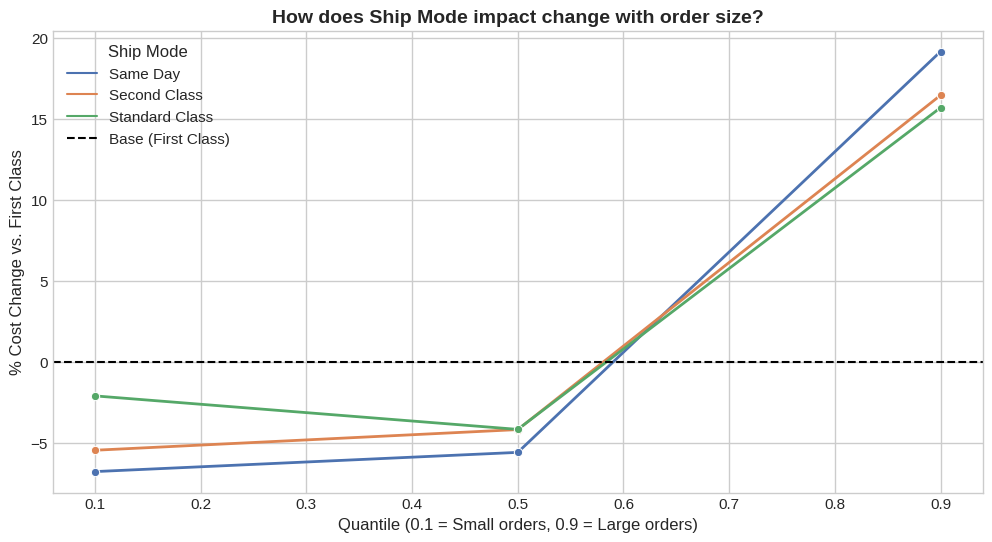

In [29]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# List of quantiles to test (10th, 50th, and 90th percentiles)
quantiles = [0.1, 0.5, 0.9]
results = []

print("Running Quantile Regression...")

# Formula remains the same (controlling for Region and Category)
formula = 'log_cost ~ C(ShipMode) + C(Region) + C(Category)'

for q in quantiles:
    # Run QuantReg model
    mod = smf.quantreg(formula, df_model)
    res = mod.fit(q=q)
    
    # Extract coefficients for Ship Modes
    coefs = res.params[res.params.index.str.contains("ShipMode")]
    
    # Extract P-values to test statistical significance
    pvalues = res.pvalues[res.params.index.str.contains("ShipMode")]
    
    # Save results
    for mode in coefs.index:
        mode_name = mode.split('[T.')[1].replace(']', '')
        results.append({
            'Quantile': q,
            'ShipMode': mode_name,
            'Coef (Log)': coefs[mode],
            'P-value': pvalues[mode],
            # Convert to actual % impact: (e^coef - 1)*100
            'Impact %': (np.exp(coefs[mode]) - 1) * 100
        })

# Convert to DataFrame for display
df_quant_results = pd.DataFrame(results)

# Pivot table for easy comparison
pivot_results = df_quant_results.pivot(index='ShipMode', columns='Quantile', values='Impact %')

print("\n=== IMPACT OF SHIP MODE ON COST (IN % COST) ===")
print("(Compared to First Class. + means more expensive, - means cheaper)")
print(pivot_results.round(2))

print("\n=== STATISTICAL SIGNIFICANCE CHECK (P-value < 0.05) ===")
significant = df_quant_results[df_quant_results['P-value'] < 0.05]
if significant.empty:
    print("No statistically significant impact at any quantile!")
else:
    print(significant[['Quantile', 'ShipMode', 'P-value', 'Impact %']])

# --- RESULT VISUALIZATION ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_quant_results, x='Quantile', y='Impact %', hue='ShipMode', marker='o', linewidth=2)
plt.axhline(0, color='black', linestyle='--', label='Base (First Class)')
plt.title('How does Ship Mode impact change with order size?', fontsize=14, fontweight='bold')
plt.xlabel('Quantile (0.1 = Small orders, 0.9 = Large orders)')
plt.ylabel('% Cost Change vs. First Class')
plt.legend(title='Ship Mode')
plt.show()